In [1]:
from torch.utils.data import Dataset, DataLoader
from Crawling_Dataset import Crawling_Nomal_Dataset
import torch
import cv2 
import os
import numpy as np
from torchvision import transforms
import torch.utils.data as data
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import math
import tqdm as tqdm
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from torchvision.transforms import Resize
# from cheff import bring

/opt/conda/envs/deepface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_path = '/opt/ml/project/data/celeb/cut_test'
train_path = '/opt/ml/project/data/celeb/cut_train'

In [3]:
transform = transforms.Compose([
        np.float32,
        transforms.ToTensor(),  # range [0, 255] -> [0.0, 1.0]
        Resize((112, 112)),
        fixed_image_standardization
    ])

In [4]:
test_dataset = Crawling_Nomal_Dataset(test_path, transforms=transform)
train_dataset = Crawling_Nomal_Dataset(train_path, transforms=transform)
test_data_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
train_data_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)

In [5]:
def get_label_per_path_dict(data_loader) :
    identities = defaultdict(lambda : list())
    # dict = {label1 : [image_path_1.jpg,image_path_2.jpg,....],
    #        label2 : [image_path_1.jpg,image_path_2.jpg,....],...}
    
    for img,  path_label in data_loader :
        img_path = path_label[0][0]
        img_label = path_label[1].tolist()[0]
        # print(img_path, img_label, sep='\n')
        identities[img_label].append(img_path)
    return identities

In [6]:
identities = get_label_per_path_dict(test_data_loader)

/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in orde

In [8]:
model_pth = '/opt/ml/project/insightface/recognition/level3_cv_finalproject-cv-14/work_dirs/wf4m_ghost/model.pt'
# model_path = '/opt/ml/insightface/recognition/arcface_torch/work_dirs/wf4m_r50_epoch20/model.pt'

In [11]:
from backbones import get_model
# from backbones.Inception_resnet import InceptionResnetV1
import pandas as pd

In [12]:
# model = InceptionResnetV1(classify=False,pretrained='vgg_casia')
# model.load_state_dict(torch.load(model_pth))

In [13]:
model = get_model('r50',)
model.state_dict(torch.load(model_pth))

TypeError: get_model() takes 1 positional argument but 2 were given

In [521]:
# model = InceptionResnetV1(
#     classify=False,
#     pretrained='vggface2'
# ).to(device)

In [522]:
def make_path_embedding_dict(FILE_PATH) :
    path_embedding_dict = {}
    model.eval()
    with torch.no_grad() :
        
        dataset = Crawling_Nomal_Dataset(FILE_PATH, transforms=transform)
        data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
        
        for feature, path_label_list in data_loader :
            # print(path_label_list)
            embeddings = get_embedding(feature)
            key = path_label_list[0][0]
            # print(key)
            value = embeddings
            path_embedding_dict[key] = value
            
    return path_embedding_dict
        

In [523]:
path2embedding = make_path_embedding_dict(test_path)

In [524]:
len(path2embedding.values())

200

In [525]:
positives = []
for key, values in idendities.items():
    # print(values)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)
# print(positives)
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"
positives.head()

,file_x,file_y,decision
0,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
1,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
2,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
3,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
4,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes


In [526]:
import itertools
samples_list = list(idendities.values())
# print(samples_list)
negatives = []
for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        # print(cross_product)
        
 
    for cross_sample in cross_product:
        negative = []
        negative.append(cross_sample[0])
        negative.append(cross_sample[1])
        negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [527]:
negatives.head()

,file_x,file_y,decision
0,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Jangdoyoun_...,No
1,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Jangdoyoun_...,No
2,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Jangdoyoun_...,No
3,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Jangdoyoun_...,No
4,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Jangdoyoun_...,No


In [528]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
df.head()
# df.file_x = "dataset/"+df.file_x
# df.file_y = "dataset/"+df.file_y
# df.head()

,file_x,file_y,decision
0,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
1,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
2,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
3,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes
4,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes


In [529]:
instances = df[["file_x", "file_y"]].values.tolist()
print(instances[0])
# path2embedding['/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong_16.jpg']

['/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong_16.jpg', '/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong_22.jpg']


In [530]:
distance_list = []
model.eval()
with torch.no_grad():
    for row in df.itertuples() :
        embedding_1 = path2embedding[row[1]]
        embedding_2 = path2embedding[row[2]]
        dist = round(distance(embedding_1, embedding_2, 1)[0],4)
        # print(dist)
        distance_list.append(dist)

df['distance'] = distance_list

In [531]:
df.decision.value_counts()

decision
No     1900
Yes     900
Name: count, dtype: int64

<Axes: ylabel='Density'>

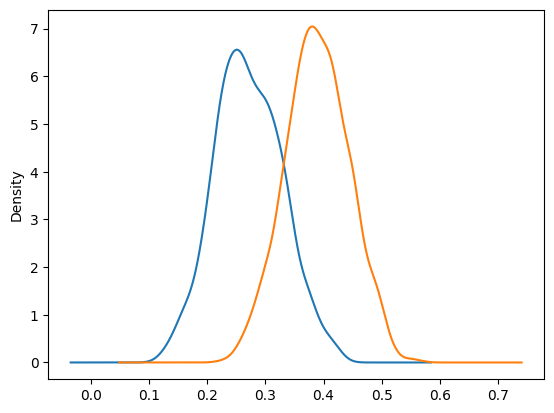

In [532]:
# KDE
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

In [533]:
p_mean = round(df[df.decision == "Yes"].distance.mean(), 4)
p_std = round(df[df.decision == "Yes"].distance.std(), 4)
n_mean = round(df[df.decision == "No"].distance.mean(), 4)
n_std = round(df[df.decision == "No"].distance.std(), 4)
print(p_mean, p_std)
print(n_mean, n_std)

0.2711 0.0574
0.3892 0.0546


In [534]:
sigma = 1 # 1, 2,..
threshold = round(p_mean + sigma * tp_std, 4)
print(threshold)

0.3188


In [535]:
df['prediction'] = 'No'
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'
df.head()

,file_x,file_y,decision,distance,prediction
0,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes,0.1907,Yes
1,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes,0.2014,Yes
2,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes,0.1878,Yes
3,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes,0.1800,Yes
4,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong...,Yes,0.2075,Yes


In [536]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df.decision.values, df.prediction.values)
print(cm)
tn, fp, fn, tp = cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)
print('acc    : ', accuracy)
print('recall : ', recall)
print('f1     : ', f1)
print('precision : ', precision)

[[1719  181]
 [ 191  709]]
acc    :  0.8671428571428571
recall :  0.7877777777777778
f1     :  0.7921787709497207
precision :  0.7966292134831461


In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [169]:
def img_loader(path) :
    try : 
        with open(path, 'rb') as f :
            img = cv2.imread(path) 
            if len(img.shape) == 2 :
                img = np.stack([img] * 3, 2)
        
            return img
    except IOError :
        print('Cannot load image' + path)

In [225]:
def img2embedding(image_path, tranform=None) :
    img = img_loader(image_path)

    if transforms is not None :
        img = transform(img)
    else :
        img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    # print(img.shape)
    embedding = get_embedding(img)
    return embedding

In [489]:
def get_embedding(feature) :
    feature = feature.to(device)
    # feature = torch.as_tensor(feature, dtype=torch.float32)
    embedding = model(feature)
    embedding = embedding.to('cpu').numpy()
    # embedding = embedding.astype(np.float32)
    return embedding

In [31]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

In [60]:
def calculate(rank_list, train_label) :
    count = 0
    for dis, label in rank_list :
        if label == train_label :
            count += 1
    return count

In [360]:
def get_embedding_from_file(FILEPATH) :
    model.eval()
    with torch.no_grad() :
        dataset = Crawling_Nomal_Dataset(FILEPATH, transforms=transform)
        data_loader = data.DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=2, drop_last=False)
        
        for feature, path_label_list in data_loader :
            embeddings = get_embedding(feature)
            print(len(path_label_list[1]))
            print(path_label_list[1])
            print(embeddings.shape)
            return embeddings, path_label_list

In [79]:
test_embeddings, path_label_list = get_embedding_from_file(test_path)

200
tensor([ 8, 19, 17, 11, 11,  9, 18, 17,  9,  4, 14, 11, 10, 14, 10,  6, 10, 14,
         7, 12,  2, 10,  2,  6,  3,  7, 16, 14, 16,  9, 17, 14,  2, 18, 13,  9,
         7,  3,  0,  9, 15, 13,  4, 13, 19,  3,  1,  3,  2,  4,  0, 12, 17,  3,
        14, 15,  4, 15, 13,  7, 11, 16,  8, 17, 14, 11,  5,  3,  9,  8, 18,  2,
        12,  4, 10,  0,  2, 19,  2,  0, 13, 14,  4,  1,  6,  6, 18, 13,  5, 16,
        17, 19,  9, 10,  3,  0, 15, 10, 16, 19,  4,  6,  1,  6,  9,  1, 17, 11,
         8, 19,  7, 11, 18, 17, 17,  6, 16,  0, 19,  0,  2,  7,  8, 16,  1, 11,
         9,  5,  5,  1,  3,  7,  3, 15,  6, 15,  1,  0, 10, 18,  1,  2, 12, 19,
         6,  5, 12,  2, 18,  0,  6, 10,  8, 11, 13,  5,  0,  4, 14, 18,  8, 18,
         5,  4, 17,  7, 12, 11, 13, 13,  3, 15,  8, 10, 14,  8,  7,  5,  8,  5,
        16, 15, 15,  7, 15, 13, 18, 12, 12,  4,  1,  9, 16,  1, 12, 12,  5, 19,
        16, 19])
(200, 512)


In [361]:
TOP_NUM = 10
eu_ten_check_list = []
correct_count_dict = defaultdict(lambda : 0)
model.eval()
with torch.no_grad():
    for idx,(feature, b) in enumerate(tqdm.tqdm(train_embedding_loader, leave=True)) :
        train_embedding = get_embedding(feature)
        train_label = b[1].tolist()[0]
        train_image_path = b[0][0]
        eu_label_embedding_list = []

        eu_dist = distance(train_embedding, test_embeddings, 1)
        test_label_list = path_label_list[1].tolist()
        
        for pair in zip(eu_dist, test_label_list) :
            eu_label_embedding_list.append(pair)

        eu_label_embedding_list = sorted(eu_label_embedding_list)
        eu_top_rank_list = eu_label_embedding_list[:TOP_NUM]
        
        count = calculate(eu_top_rank_list, train_label)
        correct_count_dict[train_label] += count
        if count < 7 :
            eu_ten_check_list.append((train_image_path,train_label))

100%|██████████| 200/200 [00:12<00:00, 15.65it/s]


In [62]:
NUM2NAME_dict = train_dataset.get_label_dict_NUM2NAME()
NAME2NUM_dict = train_dataset.get_label_dict_NAME2NUM()
print(NUM2NAME_dict)

{0: 'Ohyeonseo', 1: 'SongJoongki', 2: 'Parkhaseon', 3: 'Jojeongseok', 4: 'Jangdoyoun', 5: 'Hanhyojoo', 6: 'Chunwoohee', 7: 'Shinsekyung', 8: 'Jokyuhyun', 9: 'Sonhuengmin', 10: 'Parknarae', 11: 'Yooyeonseok', 12: 'Yimsiwan', 13: 'Leeseungki', 14: 'Parkjiseong', 15: 'Leegookju', 16: 'BTSjhin', 17: 'BTSsuga', 18: 'Ahnyoungmi', 19: 'Taeyeon'}


<BarContainer object of 20 artists>

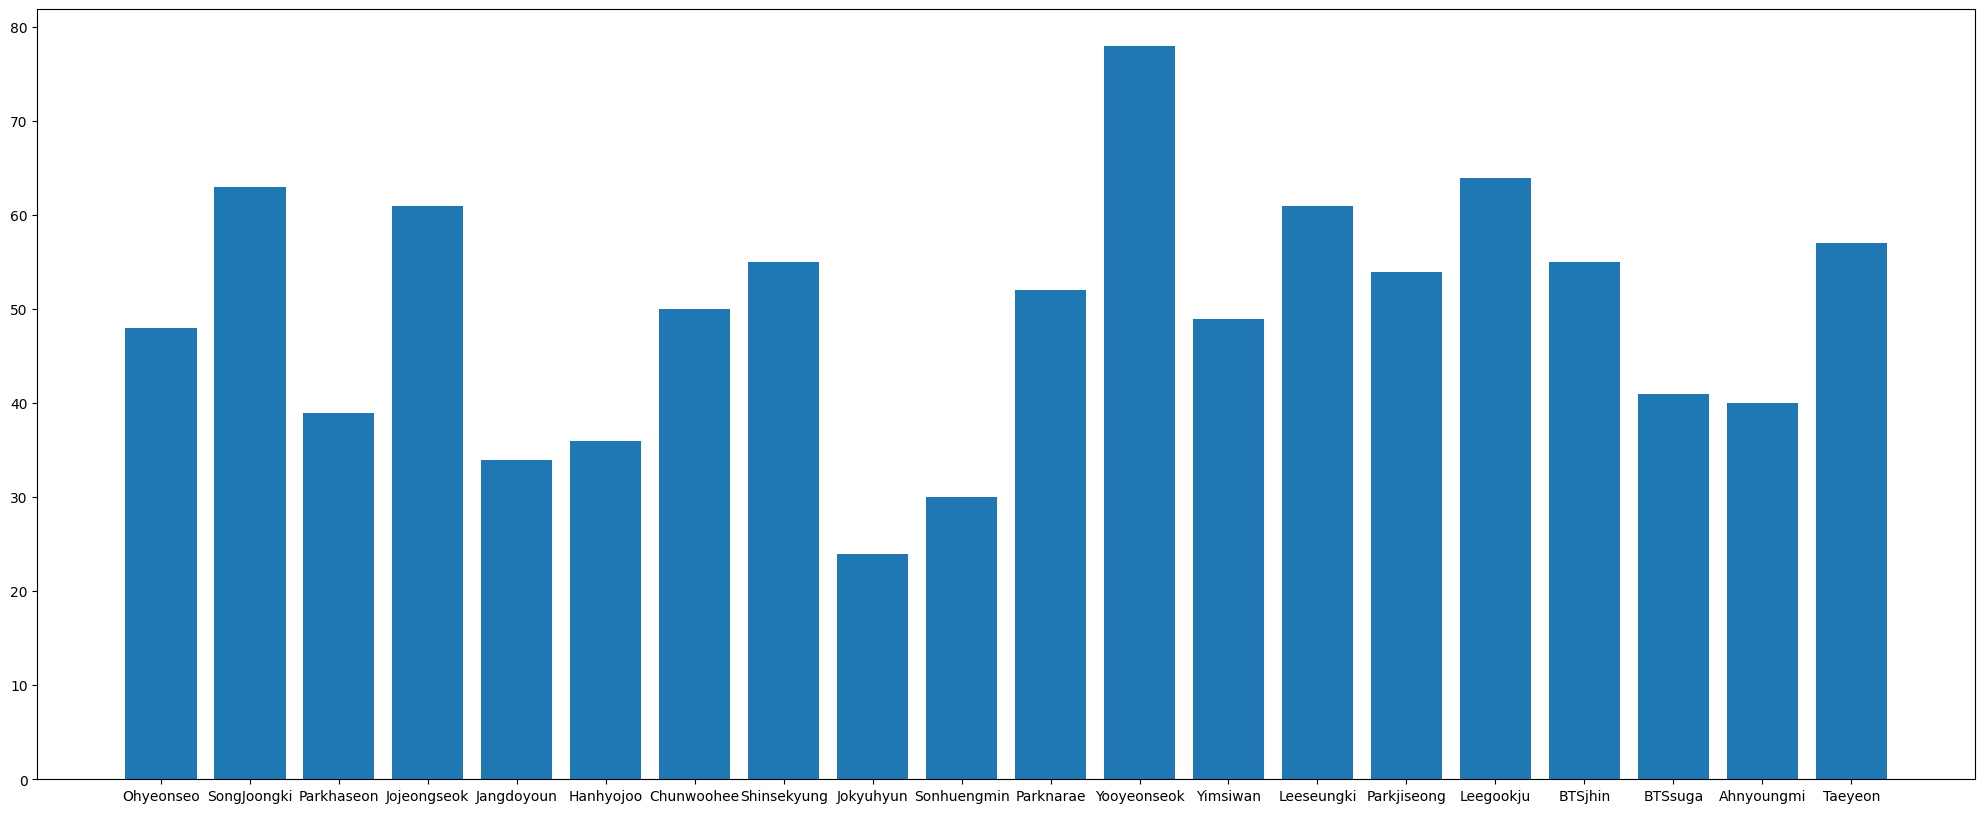

In [83]:
item = correct_count_dict.items()
item = sorted(item)
name = []
counts = []
for label, count in item :
    name.append(NUM2NAME_dict[label])
    counts.append(count)
plt.figure(figsize=(25,10))
plt.bar(name, counts)